# FindUPO Guide
------------------------------
alexei.stepa@gmail.com

In [1]:
import chaos_control as cc
from math import *
import matplotlib.pyplot as plt
import numpy as np

## Abstract

`FindUPO` is a tool designed to find accurate estimates for periodic orbits and fixed points of chaotic maps. It does this by obtaining guesses for the location of fixed points by identifying clusters of reccuring points using a machine learning algorithm then uses local optimisation to turn the guesses into accurate estimates. Accurate estimates of UPOs in chaotic systems can be used, for example, in the control of chaotic systems or to make long-time predictions of dynamical averages.
http://www.scholarpedia.org/article/Unstable_periodic_orbits
http://yorke.umd.edu/Yorke_papers_most_cited_and_post2000/1990_06_OGY_PRL_Controlling_chaos.pdf

## Introduction

Firstly, if the system you are interested in finding periodic orbits of is a continous dynamical system, you need to convert it into a map by taking a Poincare section. Fixed points and periodic orbits of the Poincare map correspond to periodic orbits of system of ODEs. The map must display ergodic behaviour, meaning that for some region of the state space and any point in that region the system will come arbitrarily close to that point, given enough time. This means that the system will eventually come arbitrarily close to fixed points. Since points close to the fixed point move only slightly after an application of the map this gives us an indication of the presence of the fixed point, even if that fixed point is unstable. This is sometimes known as the phenomena of reccurence. 

To explain reccurence mathematically, consider a continuous chaotic map $ f:M \to M $ with a fixed points $ x^{*} \in M$. The (squared) distance that a point in the state space moves is given by the function $ \Delta = |x - f(x)|^{2} $. At the fixed point, $x^{*} = f(x^{*})$, so, $\Delta (x^{*})=0 $. The map is assumed ergodic so given any nhood $U$ of $x^{*}$ and any $x \in M$, $x$ will eventually enter $U$ (i.e. there exists $n \in \mathbb{N}$ such that $ f^{n}(x)\in U $). Since, $f$ is continuous, $\Delta$ is also continuous. This means that long enough chaotic time series will eventually enter a region where $\Delta$ is arbritrarily small. Since the map is chaotic and all the fixed points are assumed unstable, the trajectory will exit and reenter these sort of regions many times, leading to clusters reccuring points in long chaotic timeseries.

To identify these clusters we simply plot the points from a long timeseries for which $ \Delta $  is below a certian **threshold** value. In the code, the variable name for this value is `thres`. Obtaining a good value for `thres` is important for a good UPO (Unstable Periodic Orbit) search. For higher period orbits (note that a periodic orbit of length $n$ is a fixed point of the $n$th iterate of the map) there may be many clusters and it becomes cumbersome to identify them by hand. Instead we can use clustering algorithms such that scikitlearn meanshift to identify them for us. The clustering algorithm requires one variable, the **bandwidth**, whose variable name is `band`. The bandwidth determines the size of the clusters the algorithm identifies. In general, larger values of the bandwidth corresponds to larger  The `ClustPlt` widget is designed to make it easy to find good values for `band` and `thres`.

Once these values are obtained, you pass them as arguements in `FindUPO` along with a formatted time series (see `Load_Cut` or `Cut`). The code identifies the point in each cluster with the smallest $\Delta$ and uses that as a first estimate for a local optimisation procedure (scipy minimise) using $ \Delta $ as a cost function. The code then strings together all the estimates in periodic orbits and out puts a nested list of all the UPOs (which we call a UPOlist). 

## How to use it: the short version

To use `FindUPO` you must have Jupyter installed (`pip install Jupyter`) as well at the following python packages (`pip install [package name here]`):

In [2]:
import numpy as np
import scipy
import sklearn
import pandas as pd

You should also have 'chaos_control.py' in the same directory as the Jupyter notebook you are working in. Note if you've never used Jupyter: shift-Enter to run a code block.

1. Define the map as a function in python. 
2. Create a long time series either as csv or a python list/array. 
3. Create a 'cut list' using `Load_Cut` or `Cut`. This appends the $\Delta$ value to each point and selects those with $\Delta$ less than a `cutoff` value. 
4. Identify `thres` and `band` values for the cut list using `ClustPlt`. Adjust the sliders until you identify clusters which are all distinct colours. 
5. Run `FindUPO` using the cut list and values for `thres` and `band` to obtain the UPOs for a specific length. 
6. You can then join together different UPOlists using `appendUPOlist`, save a UPOlist using `saveUPOlist` or convert a UPOlist to a mathematica list using `toMathematica`.

If you have any questions or find any bugs, don't hesitate to email me!

## Example: The standard map

The standard map is a good example to study because it is analytically defined yet is physically important,
http://www.scholarpedia.org/article/Chirikov_standard_map

In [3]:
def stmap(r,K=5.6):
    pnxt = r[1] + K*sin(r[0])
    xnxt = r[0] + pnxt    
    return [xnxt%(2*pi),pnxt%(2*pi) ]


def stmapLst(r0,n,K=5.6):
    out = [r0]
    for i in range(n):
        out.append(stmap(out[-1],K))
    return out

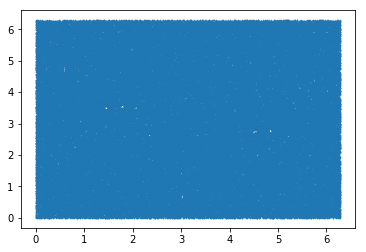

In [4]:
stmapdata = stmapLst([0.1,0.2],200000) 
plt.scatter(np.transpose(stmapdata)[0],np.transpose(stmapdata)[1],marker = '.',s=1)
plt.show()

Above, we can see the Poincare section for the standard map. For high enough value of K, the natural density for the system is fairly flat. The system variables are periodic mod $2 \pi$.

### Fixed Points

To find the fixed points for the system, we first need to create a cut list. This will remove points for which $\Delta$ is more than 0.1 and append $ \Delta$ to each datapoint.

In [5]:
cutdata1 = cc.Cut(data=stmapdata,cutoff=0.1,n=1)

We can then use `ClustPlt` to find values for threshold `thres` and the bandwidth `band`. Optional arguments `thresopt = [min,max,step]` and `bandopt = [min,max,step]` allow us to set the minimum, maximum and step size for the sliders for `thres` or `band` respectively in the widget. We found a threshold 0f 0.014 and and a bandwidth of 0.25 to work well. 

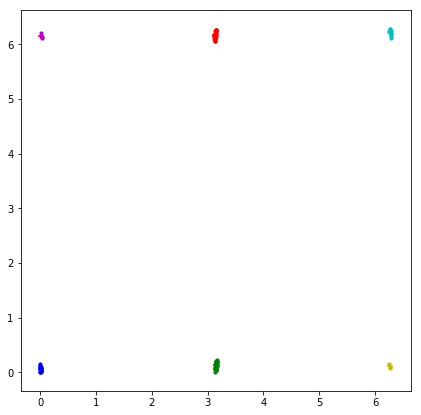

Total number of points:  88
Number of clusters:  6
Threshold:  0.03
Bandwidth:  0.244


In [6]:
cc.ClustPlt(cutdata1,thresopt = [0,0.1,0.001])

We then use `cutdata1` and the values for the threshold and bandwidth for `FindUPO`. We also need to specidy that we are searching for fixed points (`n=1`) and that the map we are using (`pmap=stmap`). 

In [7]:
UPOfixed = cc.FindUPO(data=cutdata1, n=1, thres=0.014, band=0.25, pmap = stmap)

In [8]:
UPOfixed

[[1, [[3.1415919361116815, 6.283177500984194]]],
 [1, [[3.1415926949135557, 3.9782884558341104e-07]]],
 [1, [[-7.186795672996014e-07, 7.891339378900052e-06]]],
 [1, [[6.2831856272909, 6.283181669549119]]],
 [1, [[6.2831845574195695, 4.831382754025577e-06]]],
 [1, [[1.1689946964124786e-06, 6.283177593139955]]]]

Above, we see the results. If you solve for the fixed points analytically, you find that there are two fixed points $(0,0)$ and $(\pi,0)$. Since these are exactly on the boundary the algorithm finds fixedpoints either side of the boundary. In general,this will no occur because the boundary is a set of measure zero. We simply choose 2 in this case.

In [9]:
UPOfixed = [UPOfixed[1],UPOfixed[3]]

In [10]:
UPOfixed

[[1, [[3.1415926949135557, 3.9782884558341104e-07]]],
 [1, [[6.2831856272909, 6.283181669549119]]]]

### Higher periodic orbits

A good strategy for searching for periodic orbits of various lengths is to find values for `thres` and `band` that work for a some lower period and for some higher period, then just use those values for all periods inbetween the lower and higher period. For example, here we find a value that works for n = 2 and n = 22 to try to find UPOs up to length 22. 

First we need make a long trajectory.

In [11]:
cc.ExportTimeSeries(filename = 'stmapdata.csv',r0 = [0.1,0.1],n=2000000,pmapLst=stmapLst)

Next, we create a list full of cut lists of all the different period lengths, e.g. `cutdata[2]` is a cut list for period 4. 

In [12]:
cutdata = []
for i in range(21):
    cutdata.append(cc.Load_Cut('stmapdata.csv',0.1,i+2))

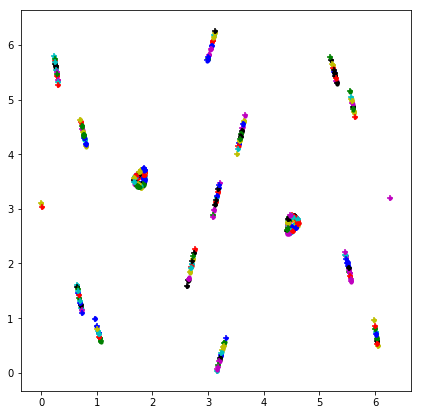

Total number of points:  1029
Number of clusters:  229
Threshold:  0.057999999999999996
Bandwidth:  0.02


In [13]:
cc.ClustPlt(cutdata[0],thresopt = [0,0.1,0.001],bandopt = [0,2,0.01] )

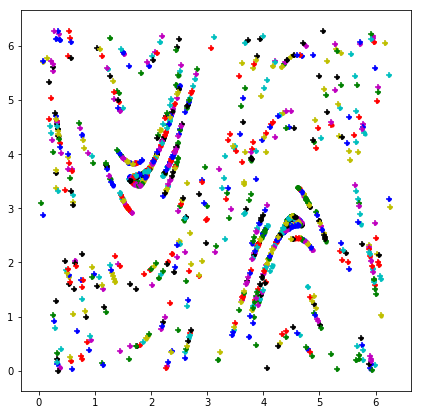

Total number of points:  1913
Number of clusters:  802
Threshold:  0.057999999999999996
Bandwidth:  0.02


In [14]:
cc.ClustPlt(cutdata[2],thresopt = [0,0.1,0.001],bandopt = [0,1,0.01])

Generally, a smaller bandwidth and a larger threshold will produce more estimates, increasing the chances of finding more UPOs at the expense of the algorithm taking longer to complete. We choose a value of 0.058 for `thres` and 0.02 for `band`. As you can see from the fist cluster plot this clearly produces too many estimates for n = 2, but thats ok since `FindUPO` ensures that no UPOs are the same (with the exception being fixed points on the boundary). If two points are within a distance `tooclose` of each other they are regarded the same.

In [15]:
UPOlistlist = [] 
for i in range(20): # WARNING: This takes a little while (a few min), but you can change 20 to smaller num if just testing
    UPOlistlist.append(cc.FindUPO(data = cutdata[i], n = i+2, thres = 0.058, band = 0.02, pmap = stmap,tooclose = 0.0001))

Using `appendUPOlists` we can join together all the UPOlists for the seperate period into one UPOlists containing all the different periods.

In [16]:
fullUPOlist = cc.appendUPOlist(UPOfixed,UPOlistlist[0],stmap)
for i in range(len(UPOlistlist) - 1):
    fullUPOlist = cc.appendUPOlist(fullUPOlist,UPOlistlist[i+1],stmap)

In [17]:
len(fullUPOlist)

195

We have managed to find 195 UPOs for the standard map. 

For Poincare maps which are not analytically defined, `FindUPO` may take a little while. For this reason you can save UPOlists with `saveUPOlist`. The UPOlists are saved as pickle `.p` files since this type of file preserves the nested list structure. 

In [18]:
cc.saveUPOlist(fullUPOlist,'stmapUPO.p')

You can load the saved pickle files with `loadUPOlist`.

In [19]:
loadedlist = cc.loadUPOlist('stmapUPO.p')

Finally, if you would like to import the UPOlist into Mathematica, you can do so using the `toMathematica` function, which will either print the Mathematica list...

In [20]:
cc.toMathematica(UPOlistlist[0])

[[1, [[3.1415923567286193, -1.4092026032640382e-06]]], [2, [[1.7690027999109383, 3.5380056069958123], [4.514182492440581, 2.745179692529643]]], [2, [[3.587794919868036, 4.349912392456878], [5.52106792742541, 1.933273007557374]]], [2, [[1.0229851114313881, 0.7513273593507477], [0.27165972485607437, 5.531859920604273]]], [2, [[0.7621171813290712, 4.349913192479792], [2.6953903181657193, 1.9332731368366485]]], [2, [[5.598159107358554, 4.913134658404882], [0.6850259733216486, 1.3700521731426805]]], [2, [[5.260199614486673, 5.531860259142722], [6.01152561707401, 0.7513260025873372]]], [2, [[3.1415926963760596, 1.214658014649664e-07], [3.141592578238769, 6.283185189042296]]], [2, [[-4.6291690364172853e-07, 3.1415954489522635], [3.1415923937006998, 3.1415928566176032]]]]


... or export to a text file (preferable if the list is large).

In [21]:
cc.toMathematica(fullUPOlist,printer = False, filename = 'fullUPOMathmtca.txt')

Below, you'll find a reference with all the functions discussed as well as some additional ones (such as a Jacobian finder) and also some chaotic maps. 

## Reference

### UPO Finder

ExportTimeSeries(filename,r0,n,pmapLst)


    Exports time-series to a csv file.
    
    filename: name of csv file in form 'file.csv'
    r0: [list] Intial point.
    n: [Integer] Number of points.
    pmapLst: [pmapLst(r0,n)] Function giving time-series.

Load_Cut(datafile, cutoff, n, maxpts = 200000)


    Loads csv data and calculates how far each point moves after a specified number of  applications of the map (appended at the end of each datapoint). Chooses points that move less than a specificied cut-off value. Returns array.
    
    filename: name of csv file in form 'file.csv'
    cutoff: maximum distance cutoff value [positive float]
    n: number of iterations of the map [positive integer]
    maxpts:  maximum number of points [positive integer] (optional)
    
Cut(data, cutoff, n, maxpts = 200000)
    
    Takes map trajectory and calculates how far each point moves after a specified number of  applications of the map
    (appended at the end of each data point). Chooses points that move less than a specificied cut-off value. Returns array.
    dara: Trajectory in form [[x1[0],...,x1[d-1]],...,[xn[0],...,xn[d-1]]] for a d dimensional space an n data points. [List or array]
    cutoff: maximum distance cutoff value [positive float]
    n: number of iterations of the map [positive integer]
    maxpts:  maximum number of points [positive integer] (optional)
    
ClustPlt_func(data, cluster, coord1 , coord2 , point_size , plot_size, thres, band, thresscale = 1, bandscale = 1)
    
    Function for interactive widget ClustPlt.
    data: [d by n] array where there are n data points and data[i] = [r0,...,rd-1,dist(r)]  for all i where dist [i] is
          distance moved by point. Load_Cut outputs this form of array.
    cluster: [True/False] Decides whether to perform clustering or not.
    coord1/coord2: [integer 0 to d-1] co-ordinate axis to plot.
    pointsize: [Float] Size of points for matplotlib scatter.
    plotsize: [Float] Size of matplotlib plot.
    thres: [Float] Maximum distance moved for a point to be plotted.
    band: [Float] Bandwidth for the clustering algorithm - roughly proportional t0 the size of clusters it will find
    RETURNS: A plot of reccurring points with different colours for different clusters if clustering is True.
   
ClustPlt(data, thresopt = [0,2,0.01], bandopt = [0,50,1])
    
    Widget for ClustPlt_func.
    data: [d + 1 by n] array where there are n data points and data[i] = [r0,...,rd-1,dist(r)]  for all i where dist [i] is
          distance moved by point. Load_Cut outputs this form of array.
    thresopt: (optional) [3 by 1 array] options for ClustPlt_func parameter thres in form [min, max, stepsize]
    bandopt: (optional) [3 by 1 array] options for ClustPlt_func parameter band in form [min, max, stepsize]
    
FindUPO(data, n, thres, band, pmap, cluster = True,cutoff = 10`**`(-6),tooclose = 0.01,opttimes = 1)

    
    ------------------------------------------------------------------------------------------------
    FindUPO: Finds estimates for locations Unstable Periodic Orbits in phase space for chaotic maps.
    ------------------------------------------------------------------------------------------------
    The initial guesses are obtained by identifying clusters of reccurring points in phase space and
    choosing the one that moves the least. The initial guesses are then turned into accurate estimates
    using local optimization. The estimates are then organized into their orbits. The algorithm ensures
    that all the UPOs are distinct.

    data: [List exported by Load_Cut] See Load_Cut. This is the initial data that the guesses are obtained from.
    n: [Positive integer] See Load_cut. Highest period of UPO that we look for. The algorithm may also identify
       UPOs with length of the divisors of n. Must be the same n as was used in Load_Cut.
    thres: [Positive Float] Our initial cut-off for the distance moved by a point after n iterations of the map.
           To obtain a good value for thres, see ClustPlt.
    band: [Positive Float] Bandwidth for the clustering algorithm. Larger values correspond to larger clusters in general.
           To obtain a good value for thres, see ClustPlt.
    pmap: [function] map in question.
    cluster: [Boolean] (optional) If true clustering procedure is perfored, otherwise everypoint is used as a guess.
    cutoff: [Positive Float] (optional) The largest distance that a point can move in n iterations of a map to be considered a UPO.
    tooclose: [Positive Float] (optional) Farthest distance between two points to be considered seperate.
    optimes: [Positive Integer] (optional) Number of times local optimisation is performed. A value higher than 1 will
            increase the time taken to perform the optimisation but may increase accuracy of estimates and may increase
            the number of estimates achieved bu the algorithm, especially for higher period UPOs.

    RETURNS: Nested list of UPO periods and trajectory in form:

            UPOlist = [[n1,[r1_1,...,r1_n1]],
                                 ...
                       [nm,[rm_1,...,rm_nm]]]

            Where m is number of estimates,
                  ni is the period if the ith estimate,
                  ri_j is a d by 1 list containing the location of the jth point of the ith estimate.

    
appendUPOlist(UPOlist1, UPOlist2, pmap, tooclose = 0.01)
    
    Combines lists of UPOs exported by FindUPOs, checking that no two are the same.
    UPOlist1/UPOlist2: [Nested lists] UPO lists
    dist: [Float function of state space] (optional) Distance function used.
    tooclose: [Float] (optional) Farthest distance between two points to be considered seperate.
    
saveUPOlist(UPOlist,filename)
    
    Saves nested list, such a the UPO list exported by FindUPO to a pickle file.
    UPOlist: [Nested list] List of UPOs such as the ine exported by FindUPO
    filename: Name of file in the form: 'filename.p'

loadUPOlist(filename)

    Loads nested list, such a the UPO list exported by FindUPO from a pickle file.
    filename: Name of file in the form: 'filename.p'

toMathematica(UPOlist,printer = True, filename = False )
    
    Converts any python list to a Mathematica list and prints it and/or daves it to
    a text file.
    UPOlist: [list/array] List you wish to convert.
    printer: (optional) [boolean] Pass True/False to turn printing on/off.
    filename: (optional) [string] Name of file in form 'filename.txt'
    

### Jacobian Finder

FindJac(r,pmap,n=1)

    Finds Jacobian of the nth iterate of some map evaluated at a point r.
    r: [list/array] Point to evaluate at.
    pmap: [pmap(r)] Map in question.
    n: [pos. integer] Number of iterates of the map.
    
FindB(r,pmapb,beval)

    Finds the derivative of a map with respect to a parameter.
    r: [list/array] Point to evaluate map at.
    pmap: [pmap(r,b=#)] Map in question.
    b: [parameter] Parameter in quesion.
    beval: [float] Value of parameter to evaluate derivative.
   
JUPOB(UPOlist,pmap,pmapb,beval)

    Useful for OGY control.
    Given a UPOlist (see FindUPO), appends a list of Jacobians and B matrices
    (derivative of map with respect to the control parameter) evaluated at each
    point of the UPO. A row of the UPOlist (i.e. all the info for a single UPO)
    is given back as,
    UPOlist[i] = [n,[r1,...,rn],[Df(r1),...,Df(rn)],[B(r1),...,B(rn)]]
    UPOlist: [nested list] List of periodic orbits in format given by FindUPO.
    pmap: [pmap(r)] Map in question.
    pmapb: [pmap(r,b)] Map in question with control parameter passed as second
        parameter.
    beval: [float] Non-control value for control parameter.
    
JUPO(UPOlist,pmap)
    
    Given a UPOlist (see FindUPO), appends a list of Jacobians evaluated at each
    point of the UPO. A row of the UPOlist (i.e. all the info for a single UPO)
    is given back as,
    UPOlist[i] = [n,[r1,...,rn],[Df(r1),...,Df(rn)]]
    UPOlist: [nested list] List of periodic orbits in format given by FindUPO.
    pmap: [pmap(r)] Map in question.
    

### Control
To be extended...

acker(A,B,s)
    
    Ackermann's formula,
    https://en.wikipedia.org/wiki/Ackermann%27s_formula
    A:[matrix] Jacobian
    B:[list/array] Derivative with respect to control parameter
    s:[list] list of desired eigenvalues.
    

### Maps

In [45]:
# Henon map
def henon(r,a = 1.4,b = 0.3):
    return [1 - a*r[0]**2 + r[1], b*r[0]]

def henonLst(r0,n):
    out = [r0]
    for i in range(n):
        out.append(henon(out[-1]))
    return out

# Standard map
def stmap(r,K=5.6):
    pnxt = r[1] + K*sin(r[0])
    xnxt = r[0] + pnxt
    return [xnxt%(2*pi),pnxt%(2*pi)]

def stmapLst(r0,n):
    out = [r0]
    for i in range(n):
        out.append(stmap(out[-1]))
    return out

In [46]:
from scipy.integrate import odeint
'''
Poincare return map for average Semiclassical Duffing
r0: Initial condition [5 by 1 list\array] 
RETURNS: [5 by 1 array]
'''
def SnDuffP(r0):
    #Parameters
    Gamma = 0.1
    g = 0.3
    omega = 1
    beta = 0.2
    theta = 0
    dens = 3000
    u = 1
    u1 = u*cos(theta)
    u2 = u*sin(theta)
    
    def f(r,t):
        x = r[0]
        p = r[1]
        sx = r[2]
        sp = r[3]
        sxp = r[4]
    
        dxdt = p
        dpdt = -(beta**2)*(x**3 + 3*sx*x) + x - 2*Gamma*p + (g/beta)*cos(omega*t)
        dsxdt = 2.0*sxp + 0.5*Gamma*(1.0 - 4.0*(sxp**2 - sx + sx**2) +u1*(-1.0+4.0*((sxp**2) + sx - sx**2))+4.0*u2*(-sxp+2.0*sxp*sx))      
        dspdt = 2.0*sxp - 6.0*(beta**2)*sxp*(x**2+sx) + 0.5*Gamma*(1.0-4.0*sp-4.0*(sp**2)-4.0*sxp**2 + u1*(1.0-4.0*sp+4.0*(sp**2)-4.0*sxp**2)+4.0*u2*(-sxp+2.0*sxp*sp))       
        dsxpdt = -2.0*Gamma*(sxp*(sp+sx) - u1*sxp*(sp-sx)-0.25*u2*(1.0-2.0*sp+4.0*(sxp**2)-2.0*sx+4.0*sp*sx)) + sp +sx -3.0*(beta**2)*sx*(x**2+sx)       
        drdt = np.array([dxdt,dpdt, dsxdt, dspdt, dsxpdt])
       
        return drdt
    r0 = np.array([r0[0],r0[1],r0[2],r0[3],r0[4]])
    out = odeint(f,r0,np.linspace(0,2*pi/omega,dens))[-1]
    return out

'''
Poincare return map list for average Semiclassical Duffing (using SnDuffP)
r0: [5 by 1 array] Initial condition  
n: [positive integer] Number of points 
'''
def SnDuffPLst(r0,n):
    out = [r0]
    for i in range(0,n,1):
        out.append(SnDuffP(out[-1]))
    return out 

In [47]:
# Poincare section (stroboscopic) for Duffing oscillator.
def DuffP(r0,b = 0.125, g = 3, omega = 1):

    def f(r,t):
    
        x = r[0]
        y = r[1]
        drdt = np.array([ y, - 2*b*y + x - x**3 + g*cos(omega*t)])
        return drdt
    
    tvals = np.linspace(0,2*pi,3)
    temp = odeint(f,r0,tvals)[-1]
    return temp

def DuffPLst(r0,n):
    out = [r0]
    for i in range(0,n,1):
        out.append(DuffP(out[-1]))
    return out 